## Anime face genration using Genrative Adversarial Networks

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
## downloading dataset

url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Aadi_1801
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:05<00:00, 74.4MB/s]


In [ ]:
url2 = 'https://www.kaggle.com/datasets/subinium/highresolution-anime-face-dataset-512x512'
od.download(url2)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Aadi_1801
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/subinium/highresolution-anime-face-dataset-512x512


100%|██████████| 15.0G/15.0G [08:07<00:00, 33.1MB/s]


In [ ]:
import os
data_dir = './animefacedataset'
print(os.listdir(data_dir))

['images']


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader  ## groups data into minibatches for efficient processing + prallel data loading
import torchvision.transforms as tt ## image transformation and tensor transformation
##  resizing, cropping, flipping, rotation, color adjustments
##  Converts PIL images to tensors, normalizes tensors, and performs tensor-specific operations

In [ ]:
img_size = 64 ## pixel size
batch_size = 128   ## how many images are processed simultaneously during each training iteration
# mean of 0.5 and std dev of 0.5
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

## defines the statistics used for normalization of image data
## The first tuple (0.5, 0.5, 0.5) represents the mean values for each channel (Red, Green, Blue) in the image & 2nd for std dev.

In [ ]:
train_ds = ImageFolder(data_dir , tt.Compose([
    # converting image
    tt.Resize(img_size),
    # center crop image
    tt.CenterCrop(img_size),
    # converting image to tensor
    tt.ToTensor(),
    # normalizing dataset
    tt.Normalize(*stats)
]))
# loading data
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## for denormalizing image
def denormalize(images):
  return images * stats[1][0] + stats[0][0]

In [ ]:
## converting image to original size

def show_images(images, nmax=9):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denormalize(images.cpu()[:nmax]), nrow=3).permute(1, 2, 0)) ##images.detach()
  plt.show()

In [ ]:
def show_batch(dl, nmax= 9):
  for images, _ in dl:
    show_images(images)
    break

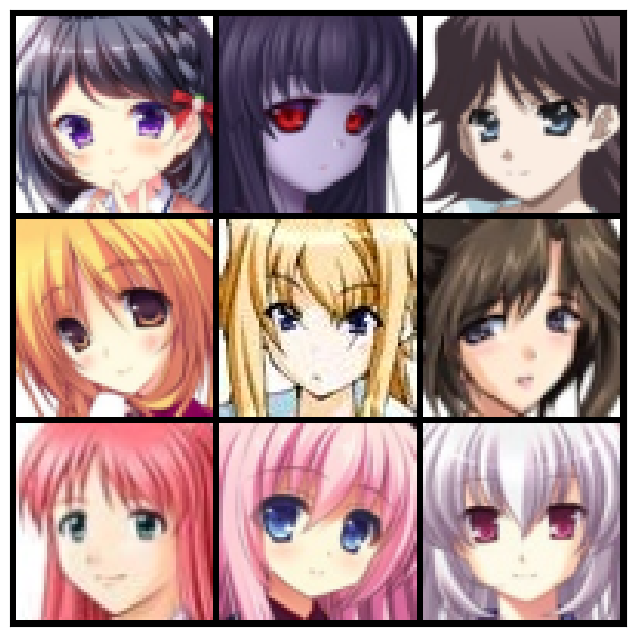

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
device = get_default_device()

In [ ]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, get_default_device())

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
## discriminator model

discriminator = nn.Sequential(
    ## in 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size= 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    ## out 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    ## out 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    ## out 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    ## out 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    ## out 1 x 1 x 1
    nn.Flatten(), ## convert to 1D
    nn.Sigmoid()
    ## it will convert output in 0 or 1
    ## interpreting it as a probability (0 for fake, 1 for real)
)


In [ ]:
discriminator = to_device(discriminator, get_default_device())

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    ## in latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    ## out 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    ## out 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    ## out 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    ## out 3 x 3 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

)

torch.Size([128, 3, 64, 64])


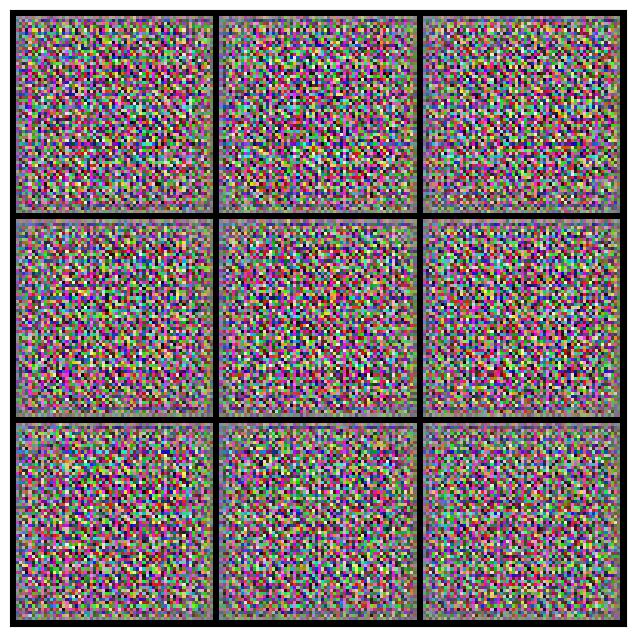

In [ ]:
## creating a latent tensor
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

# generator will genrate noise images

In [ ]:
generator = to_device(generator, get_default_device())

In [ ]:
## training our discriminator

def train_discriminator(real_images, opt_d):

  # clear gradients
  opt_d.zero_grad()

  # pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  ## pass fake images through discriminator
  fake_preds = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  ## update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  # after backward discriminator will be able to predict more accurate images
  opt_d.step() ## updating weights

  return loss.item(), real_score, fake_loss.item(), fake_score


In [ ]:
## traning generator model

def train_generator(opt_g):

  # clear gradients
  opt_g.zero_grad()

  # generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  ## pass fake images through discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(fake_images.size(0), 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
## after every epoch we will store images which is generated by our generator

In [ ]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denormalize(fake_images), fake_fname, nrow=8)
  print('Saving', fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    plt.show()

In [ ]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


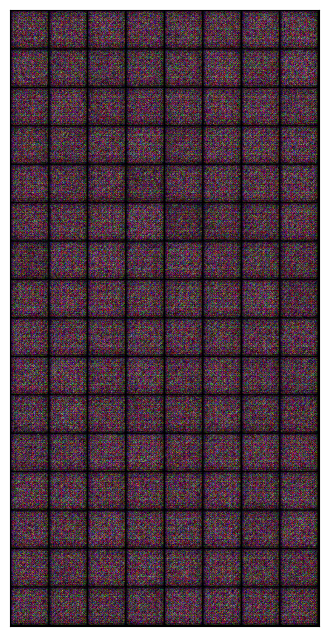

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
## progress bar
from tqdm.notebook import tqdm

In [ ]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  ## losses and scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  ## creating optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      ## train discriminator
      loss_d, real_score, loss_g, fake_score = train_discriminator(real_images, opt_d)
      # train generator
      loss_g = train_generator(opt_g)

    # record losses and scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    ## log losses and scores
    print("Epoch [{}/ {}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_d, loss_g, real_score, fake_score))

    ## save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores


In [ ]:
lr = 0.0002
epochs = 30

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-c92b1faa7f04>", line 1, in <cell line: 1>
    history = fit(epochs, lr)
  File "<ipython-input-35-ddc7ebcb3282>", line 17, in fit
    loss_d, real_score, loss_g, fake_score = train_discriminator(real_images, opt_d)
  File "<ipython-input-27-128d540e27e2>", line 30, in train_discriminator
    return loss.item(), real_score, fake_loss.item(), fake_score
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Tra

TypeError: object of type 'NoneType' has no len()

In [ ]:
from IPython.display import Image

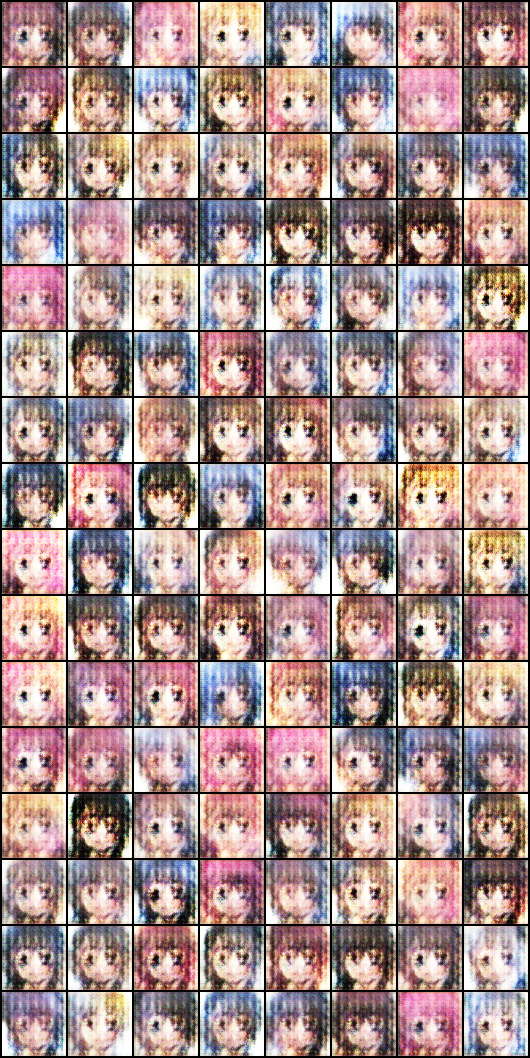

In [ ]:
Image("generated-images-0001.png")

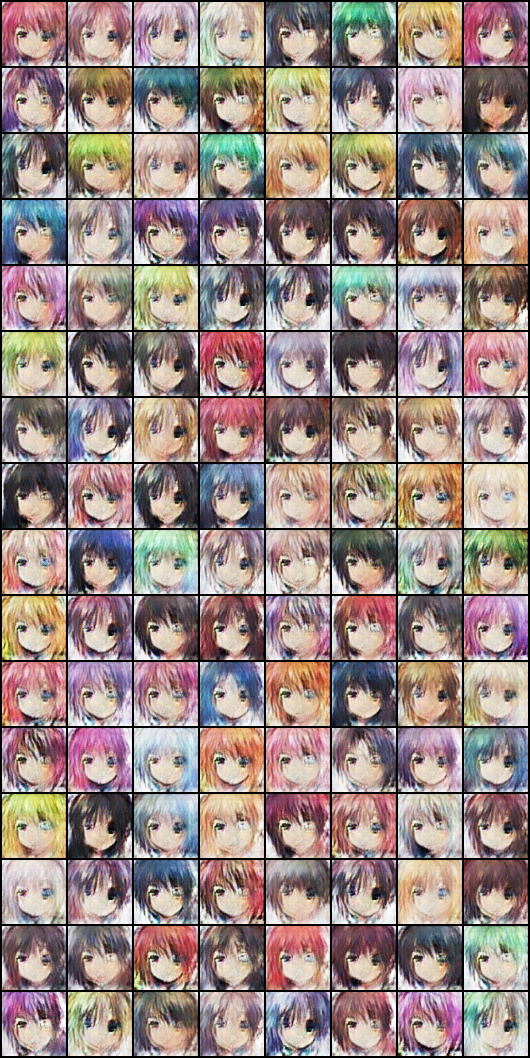

In [ ]:
Image("generated-images-0005.png")

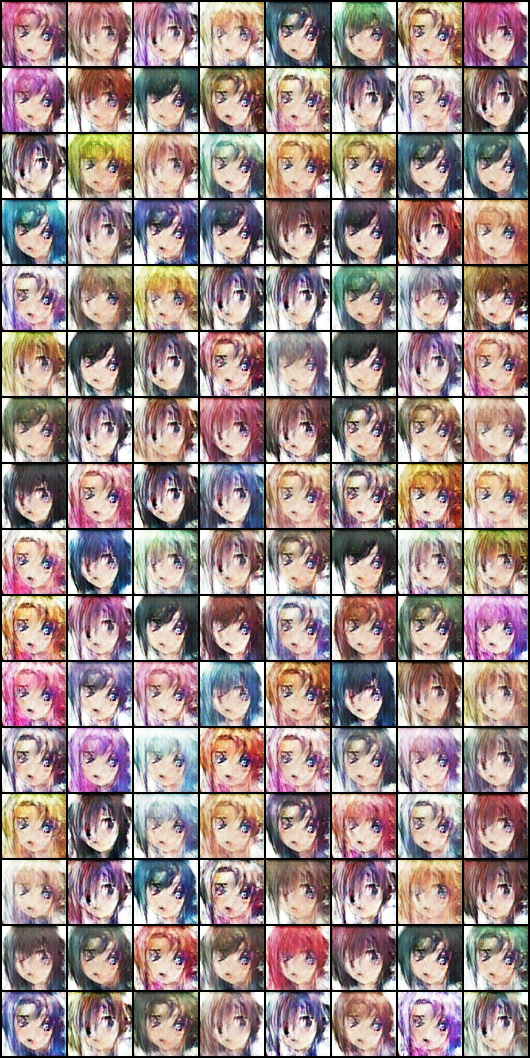

In [ ]:
Image("generated-images-0010.png")

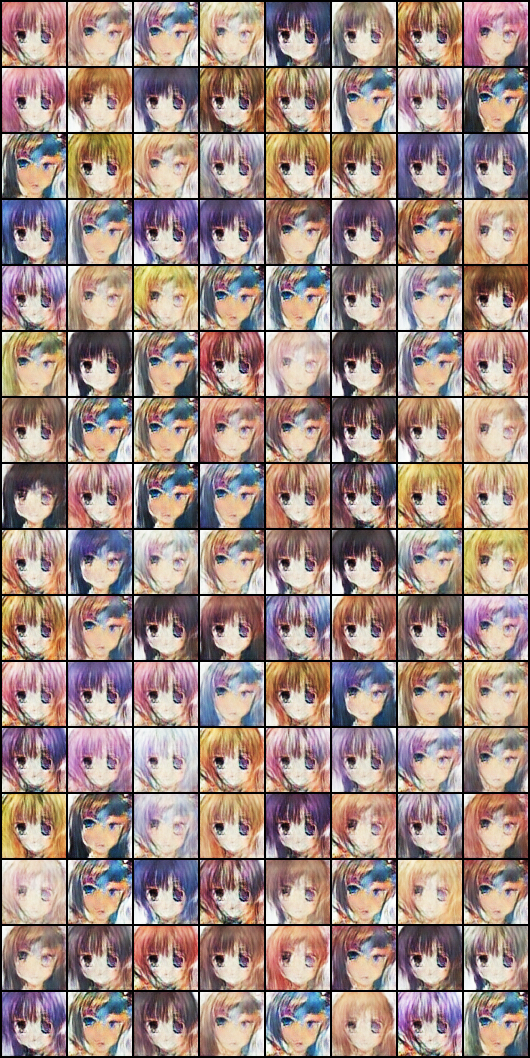

In [ ]:
Image("generated-images-0015.png")

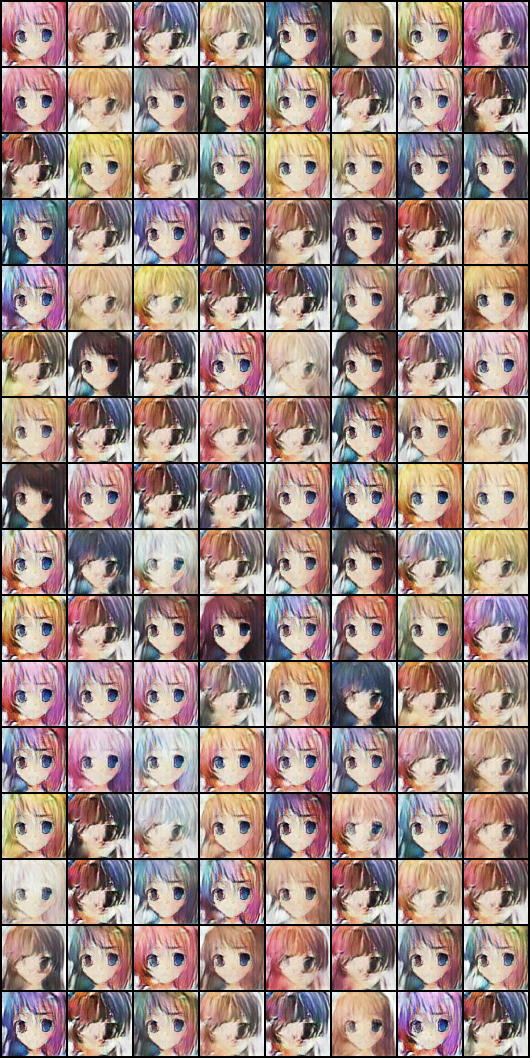

In [ ]:
Image("generated-images-0020.png")